# Python AI / ML / DL / XAI Package 배워보기

## Machine Learning Process
* Scikit-learn ( https://scikit-learn.org/stable/ )

## Machine Learning Algorithm
* Scikit Learn ( https://scikit-learn.org/stable/supervised_learning.html#supervised-learning )
    - Logistic Regression
    - KNN
    - SVM
    - Decision Tree / Random Forest
* XGboost ( https://xgboost.readthedocs.io/en/latest/ )
* LGB ( https://lightgbm.readthedocs.io/en/latest/ )
* Catboost ( https://catboost.ai/docs )
* Ngboost ( https://stanfordmlgroup.github.io/projects/ngboost/, https://github.com/stanfordmlgroup/ngboost )

## Deep Learning Algorithm
* Keras ( https://keras.io/api/ , https://www.tensorflow.org/guide/keras?hl=ko )
    - DNN / RNN / CNN / Transformer



In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=7e8a704fe68569e39d0f2fd73e8dc8b8af8be728a9827150cbfbe3fa2d80c754
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Jan 16 00:10 .
drwxr-xr-x 1 root root 4096 Jan 16 00:08 ..
drwxr-xr-x 4 root root 4096 Jan  7 14:33 .config
drwxr-xr-x 1 root root 4096 Jan  7 14:33 sample_data


# The Goal

## What're we doing?
We're going to let XGBoost, LightGBM and Catboost battle it out

- **Classification:** Classify images in the Fashion MNIST (60,000 rows, 784 features)


## How're we doing it?
In each round here are the steps we'll follow:
1. Train baseline models of XGBoost, Catboost, LightGBM (trained using the same paramaters for each model)
2. Train fine-tuned models of XGBoost, Catboost, LightGBM using GridSearchCV
3. Measure performance on the following metrics:
    - training and prediction times
    - prediction score
    - interpretability (feature importance, shap values, visualize trees)

https://lavanya.ai/2019/06/27/battle-of-the-boosting-algorithms/

In [4]:
!pip install catboost
!pip install shap
!pip install plotly

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 564 kB 13.6 MB/s 


# Setup

In [5]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from dateutil import tz
from geopy import distance
import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [6]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [106]:
# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(rmse(y_predict, model.predict(X_predict)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearch(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    if(type=='classification'):
        model = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    else:
        model = GridSearchCV(clf, params, scoring='r2', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(rmse(y_predict, model.predict(X_predict)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

In [8]:
# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 7,5
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,6)]
    xlabs=[i for i in range(0,6)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

In [9]:
# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

# Round 1: Classification: Classify images in the Fashion MNIST

## A. Explore the Fashion MNIST dataset (60000 rows, 784 features)

https://www.kaggle.com/zalando-research/fashionmnist

In [10]:
!kaggle datasets download -d zalando-research/fashionmnist
!ls -la

 71% 49.0M/68.8M [00:00<00:00, 49.2MB/s]
100% 68.8M/68.8M [00:01<00:00, 69.5MB/s]
total 70444
drwxr-xr-x 1 root root     4096 Jan 16 00:10 .
drwxr-xr-x 1 root root     4096 Jan 16 00:08 ..
drwxr-xr-x 4 root root     4096 Jan  7 14:33 .config
-rw-r--r-- 1 root root 72114846 Jan 16 00:10 fashionmnist.zip
drwxr-xr-x 1 root root     4096 Jan  7 14:33 sample_data


In [11]:
!unzip fashionmnist.zip
!ls -la

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  
total 275708
drwxr-xr-x 1 root root      4096 Jan 16 00:11 .
drwxr-xr-x 1 root root      4096 Jan 16 00:08 ..
drwxr-xr-x 4 root root      4096 Jan  7 14:33 .config
-rw-r--r-- 1 root root  22176691 Sep 21  2019 fashion-mnist_test.csv
-rw-r--r-- 1 root root 133047193 Sep 21  2019 fashion-mnist_train.csv
-rw-r--r-- 1 root root  72114846 Jan 16 00:10 fashionmnist.zip
drwxr-xr-x 1 root root      4096 Jan  7 14:33 sample_data
-rw-r--r-- 1 root root   7840016 Sep 21  2019 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root     10008 Sep 21  2019 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root  47040016 Sep 21  2019 train-images-idx3-ubyte
-rw-r--r-- 1 root root     60008 Sep 21  2019 train-labels-idx1-ubyte


In [12]:
# Read in dataset
fetch_from = 'fashion-mnist_train.csv'
train = pd.read_csv(fetch_from)

fetch_from = 'fashion-mnist_test.csv'
test = pd.read_csv(fetch_from)

In [13]:
# Perform train-test split
(X_train, y_train, X_test, y_test) = (
    train.iloc[:,1:], train['label'], test.iloc[:,1:], test['label']
)
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel456,pix

In [14]:
X_train.shape, X_test.shape
# Each image is 28*28(=784) pixels, hence the 784 features

((60000, 784), (10000, 784))

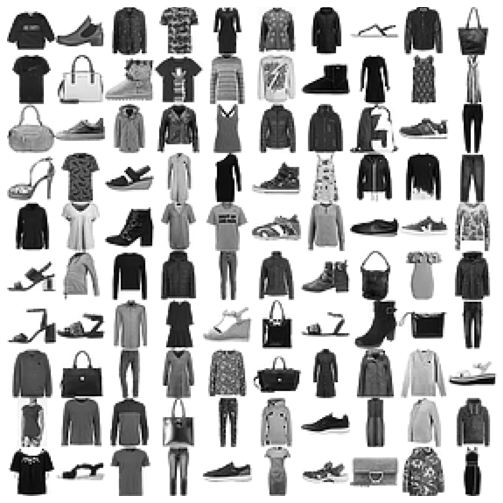

In [15]:
# Sample some images in the dataset
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
plt.figure(figsize=(9,9))
example_images = X_train[:100]
plot_digits(example_images.values, images_per_row=10)
plt.show()

## B. Baseline models

In [16]:
prediction_times = []
training_times = []
scores = []

### XGBoost

In [17]:
xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train[:100], y_train[:100], X_test, y_test)

Training time: 
Execution Time: 00:00:02

Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [18]:
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5), X_train[:100], y_train[:100], X_test, y_test)

Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [19]:
cat = Train(
    CatBoostClassifier(iterations=10, random_state=42, silent = False), 
    X_train[:100], y_train[:100], X_test, y_test
)

Learning rate set to 0.5
0:	learn: 2.0850980	total: 208ms	remaining: 1.87s
1:	learn: 1.8341305	total: 364ms	remaining: 1.46s
2:	learn: 1.6705174	total: 518ms	remaining: 1.21s
3:	learn: 1.5232341	total: 673ms	remaining: 1.01s
4:	learn: 1.3825259	total: 842ms	remaining: 842ms
5:	learn: 1.2816626	total: 997ms	remaining: 665ms
6:	learn: 1.1862655	total: 1.16s	remaining: 496ms
7:	learn: 1.0760769	total: 1.31s	remaining: 328ms
8:	learn: 0.9854166	total: 1.47s	remaining: 163ms
9:	learn: 0.8957584	total: 1.62s	remaining: 0us
Training time: 
Execution Time: 00:00:02

Prediction time: 
Execution Time: 00:00:00


## C. Fine-tuned models

### XGBoost

In [20]:
# XGBoost with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[10],
           'learning_rate':[0.1],
           'colsample_bytree':[0.95]}]
xgboost_gs = GridSearch(XGBClassifier(random_state=42), param_grid, X_train[:100], y_train[:100], X_test, y_test)

Training time: 
Execution Time: 00:00:03
Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [21]:
# LightGBM with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[10],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
lgb_gs = GridSearch(LGBMClassifier(random_state=42), param_grid, X_train[:100], y_train[:100], X_test, y_test)

Training time: 
Execution Time: 00:00:03
Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [22]:
# CatBoost with GridSearch
start = time.time()
param_grid=[{'depth':[5],
            'learning_rate':[1]}]
cat_gs = GridSearch(
    CatBoostClassifier(
        iterations=10, random_state=42, silent = False
    ), 
    param_grid, X_train[:100], y_train[:100], X_test, y_test
)

0:	learn: 1.9348848	total: 117ms	remaining: 1.05s
1:	learn: 1.6337114	total: 216ms	remaining: 863ms
2:	learn: 1.3390939	total: 311ms	remaining: 726ms
3:	learn: 1.0964924	total: 411ms	remaining: 617ms
4:	learn: 0.9354715	total: 517ms	remaining: 517ms
5:	learn: 0.7844366	total: 620ms	remaining: 413ms
6:	learn: 0.6733668	total: 716ms	remaining: 307ms
7:	learn: 0.5555127	total: 812ms	remaining: 203ms
8:	learn: 0.4959040	total: 911ms	remaining: 101ms
9:	learn: 0.4372975	total: 1.01s	remaining: 0us
Training time: 
Execution Time: 00:00:07
Prediction time: 
Execution Time: 00:00:00


## D. The Results

In [23]:
# free up memory be deleting dataframes no longer needed
del [[y_train, X_test, y_test, train, test]]

In [24]:
models = [
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('XGBoost GridSearch', xgboost_gs),
    ('LightGBM GridSearch', lgb_gs),
    ('CatBoost GridSearch', cat_gs)
]

### Accuracy Scores

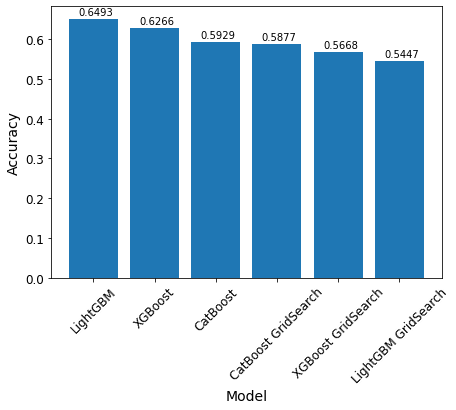

In [25]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

### Training and Prediction Times

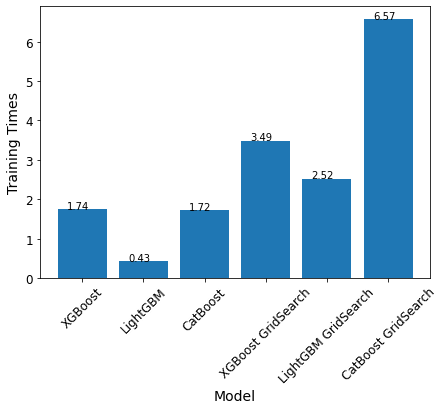

In [26]:
training_times = [round(time,2) for time in training_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Training Times': training_times })
plot_metric(model_train_times, score='Training Times')

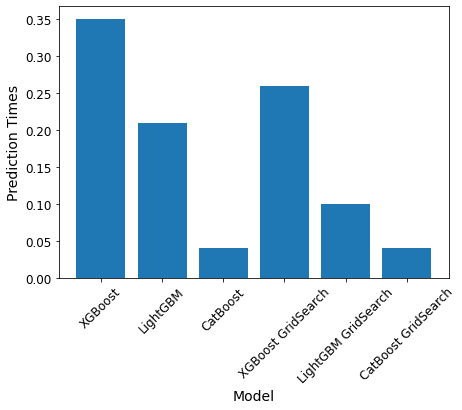

In [27]:
prediction_times = [round(time,2) for time in prediction_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Prediction Times': prediction_times })
plot_metric(model_train_times, score='Prediction Times')

### Interpretability

A model's prediction score only paints a partial picture of its predictions. We also want to know *why* the model is making its predictions.

Here we plot the model's feature importances, SHAP values and draw an actual decision tree to get a firmer understanding of the model's predictions.

#### Feature Importances

      feature  importance
144  pixel145    0.044043
295  pixel296    0.034064
407  pixel408    0.028846
166  pixel167    0.028727
442  pixel443    0.026295
172  pixel173    0.023686
165  pixel166    0.021076
604  pixel605    0.020857
694  pixel695    0.019699
615  pixel616    0.017602


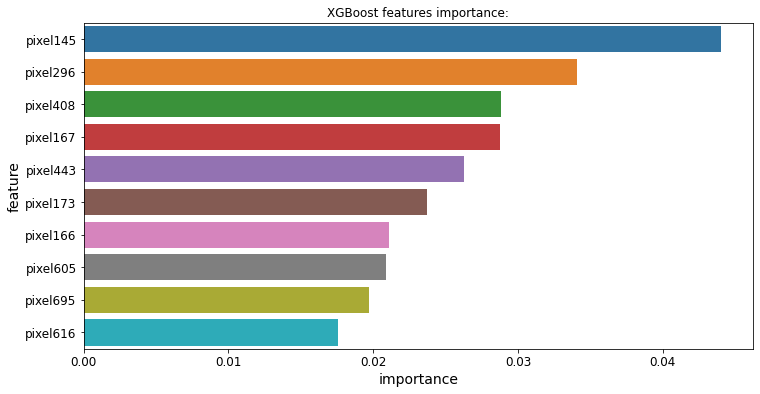

In [28]:
# XGBoost
feature_importances(X_train, xgboost, 'XGBoost')

      feature  importance
180  pixel181    3.766364
243  pixel244    3.712921
440  pixel441    3.512212
411  pixel412    3.427127
452  pixel453    3.215207
217  pixel218    3.102695
415  pixel416    3.031593
446  pixel447    2.964721
602  pixel603    2.925063
468  pixel469    2.863861


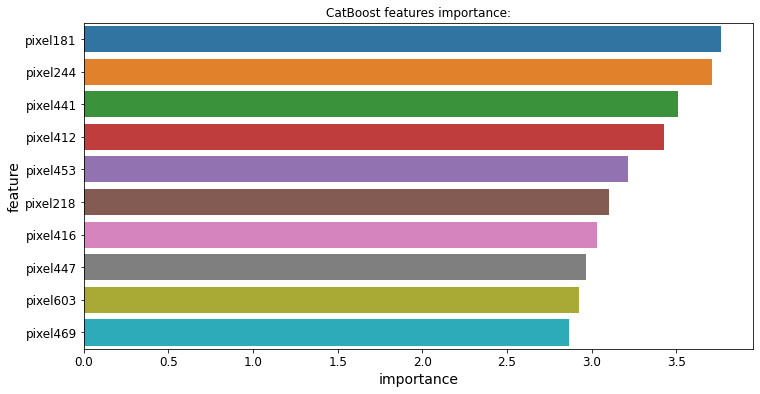

In [29]:
# CatBoost
feature_importances(X_train, cat, 'CatBoost')

      feature  importance
155  pixel156          23
602  pixel603          23
469  pixel470          22
67    pixel68          22
117  pixel118          20
691  pixel692          18
686  pixel687          17
343  pixel344          17
471  pixel472          16
268  pixel269          16


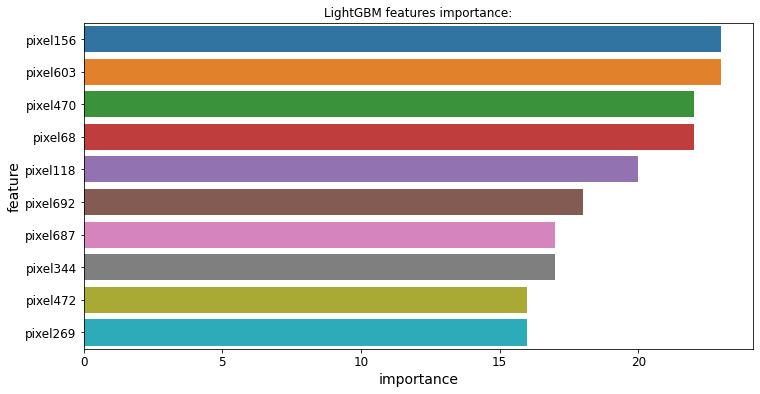

In [30]:
# LightGBM
feature_importances(X_train, lgb, 'LightGBM')

#### SHAP Values

Reference table for understanding which class names the class indexes refer to in the graphs below:

| Class | Name |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

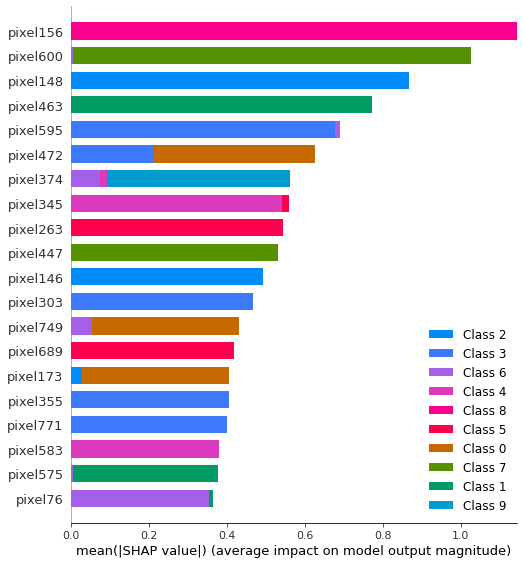

In [31]:
# XGBoost
shap_values(X_train.iloc[:500,:], xgboost, 'XGBoost')

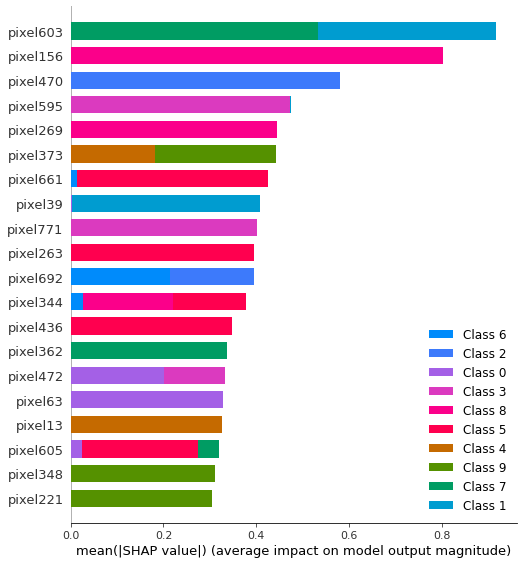

In [32]:
# LightGBM
shap_values(X_train.iloc[:500,:], lgb, 'LightGBM')

**CatBoost**
CatBoost doesn't work out of the box with shap_values() and results in the kernel crashing.

#### Visualize Trees

In [33]:
# Set figure size for decision tree plots
rcParams['figure.figsize'] = 80,50

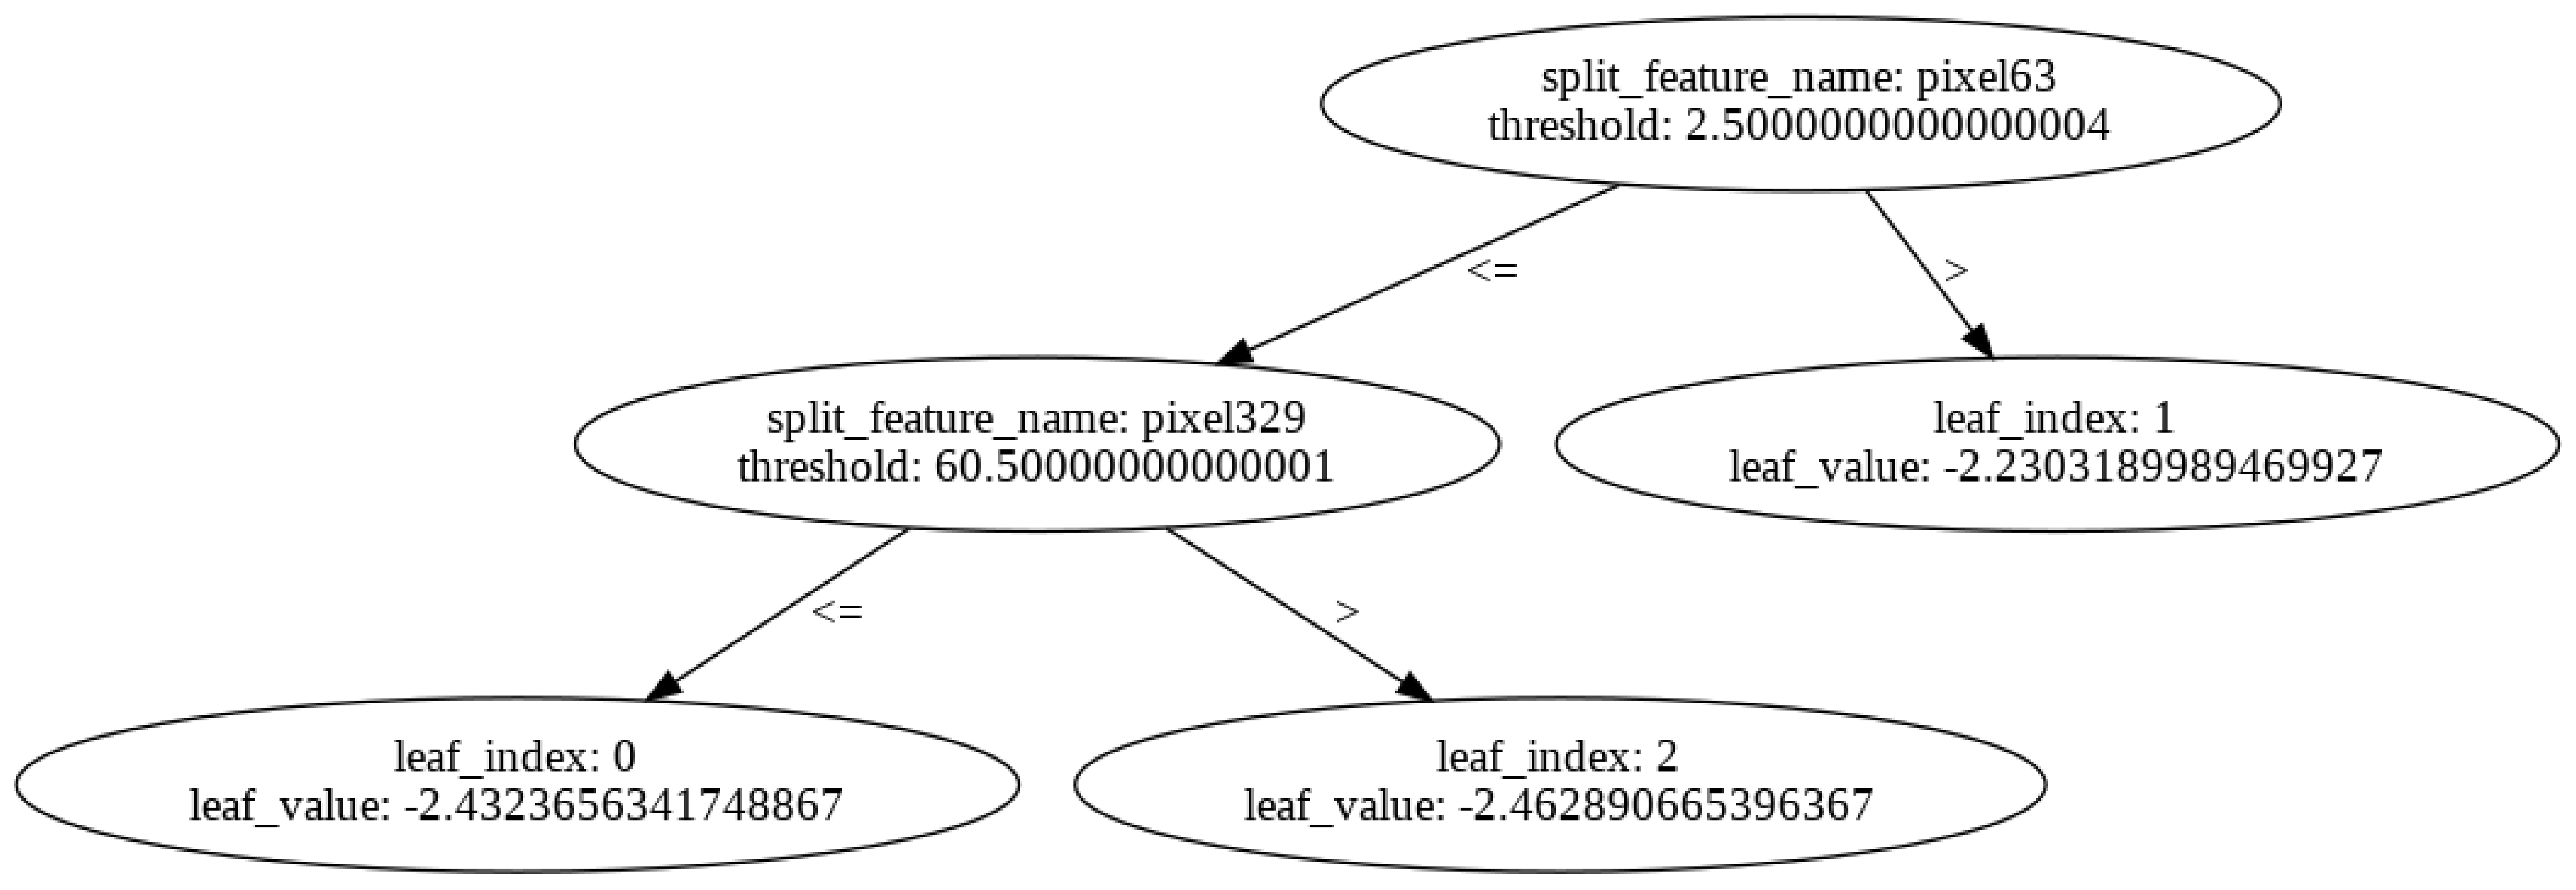

In [34]:
# LightGBM
lightgbm.plot_tree(lgb);

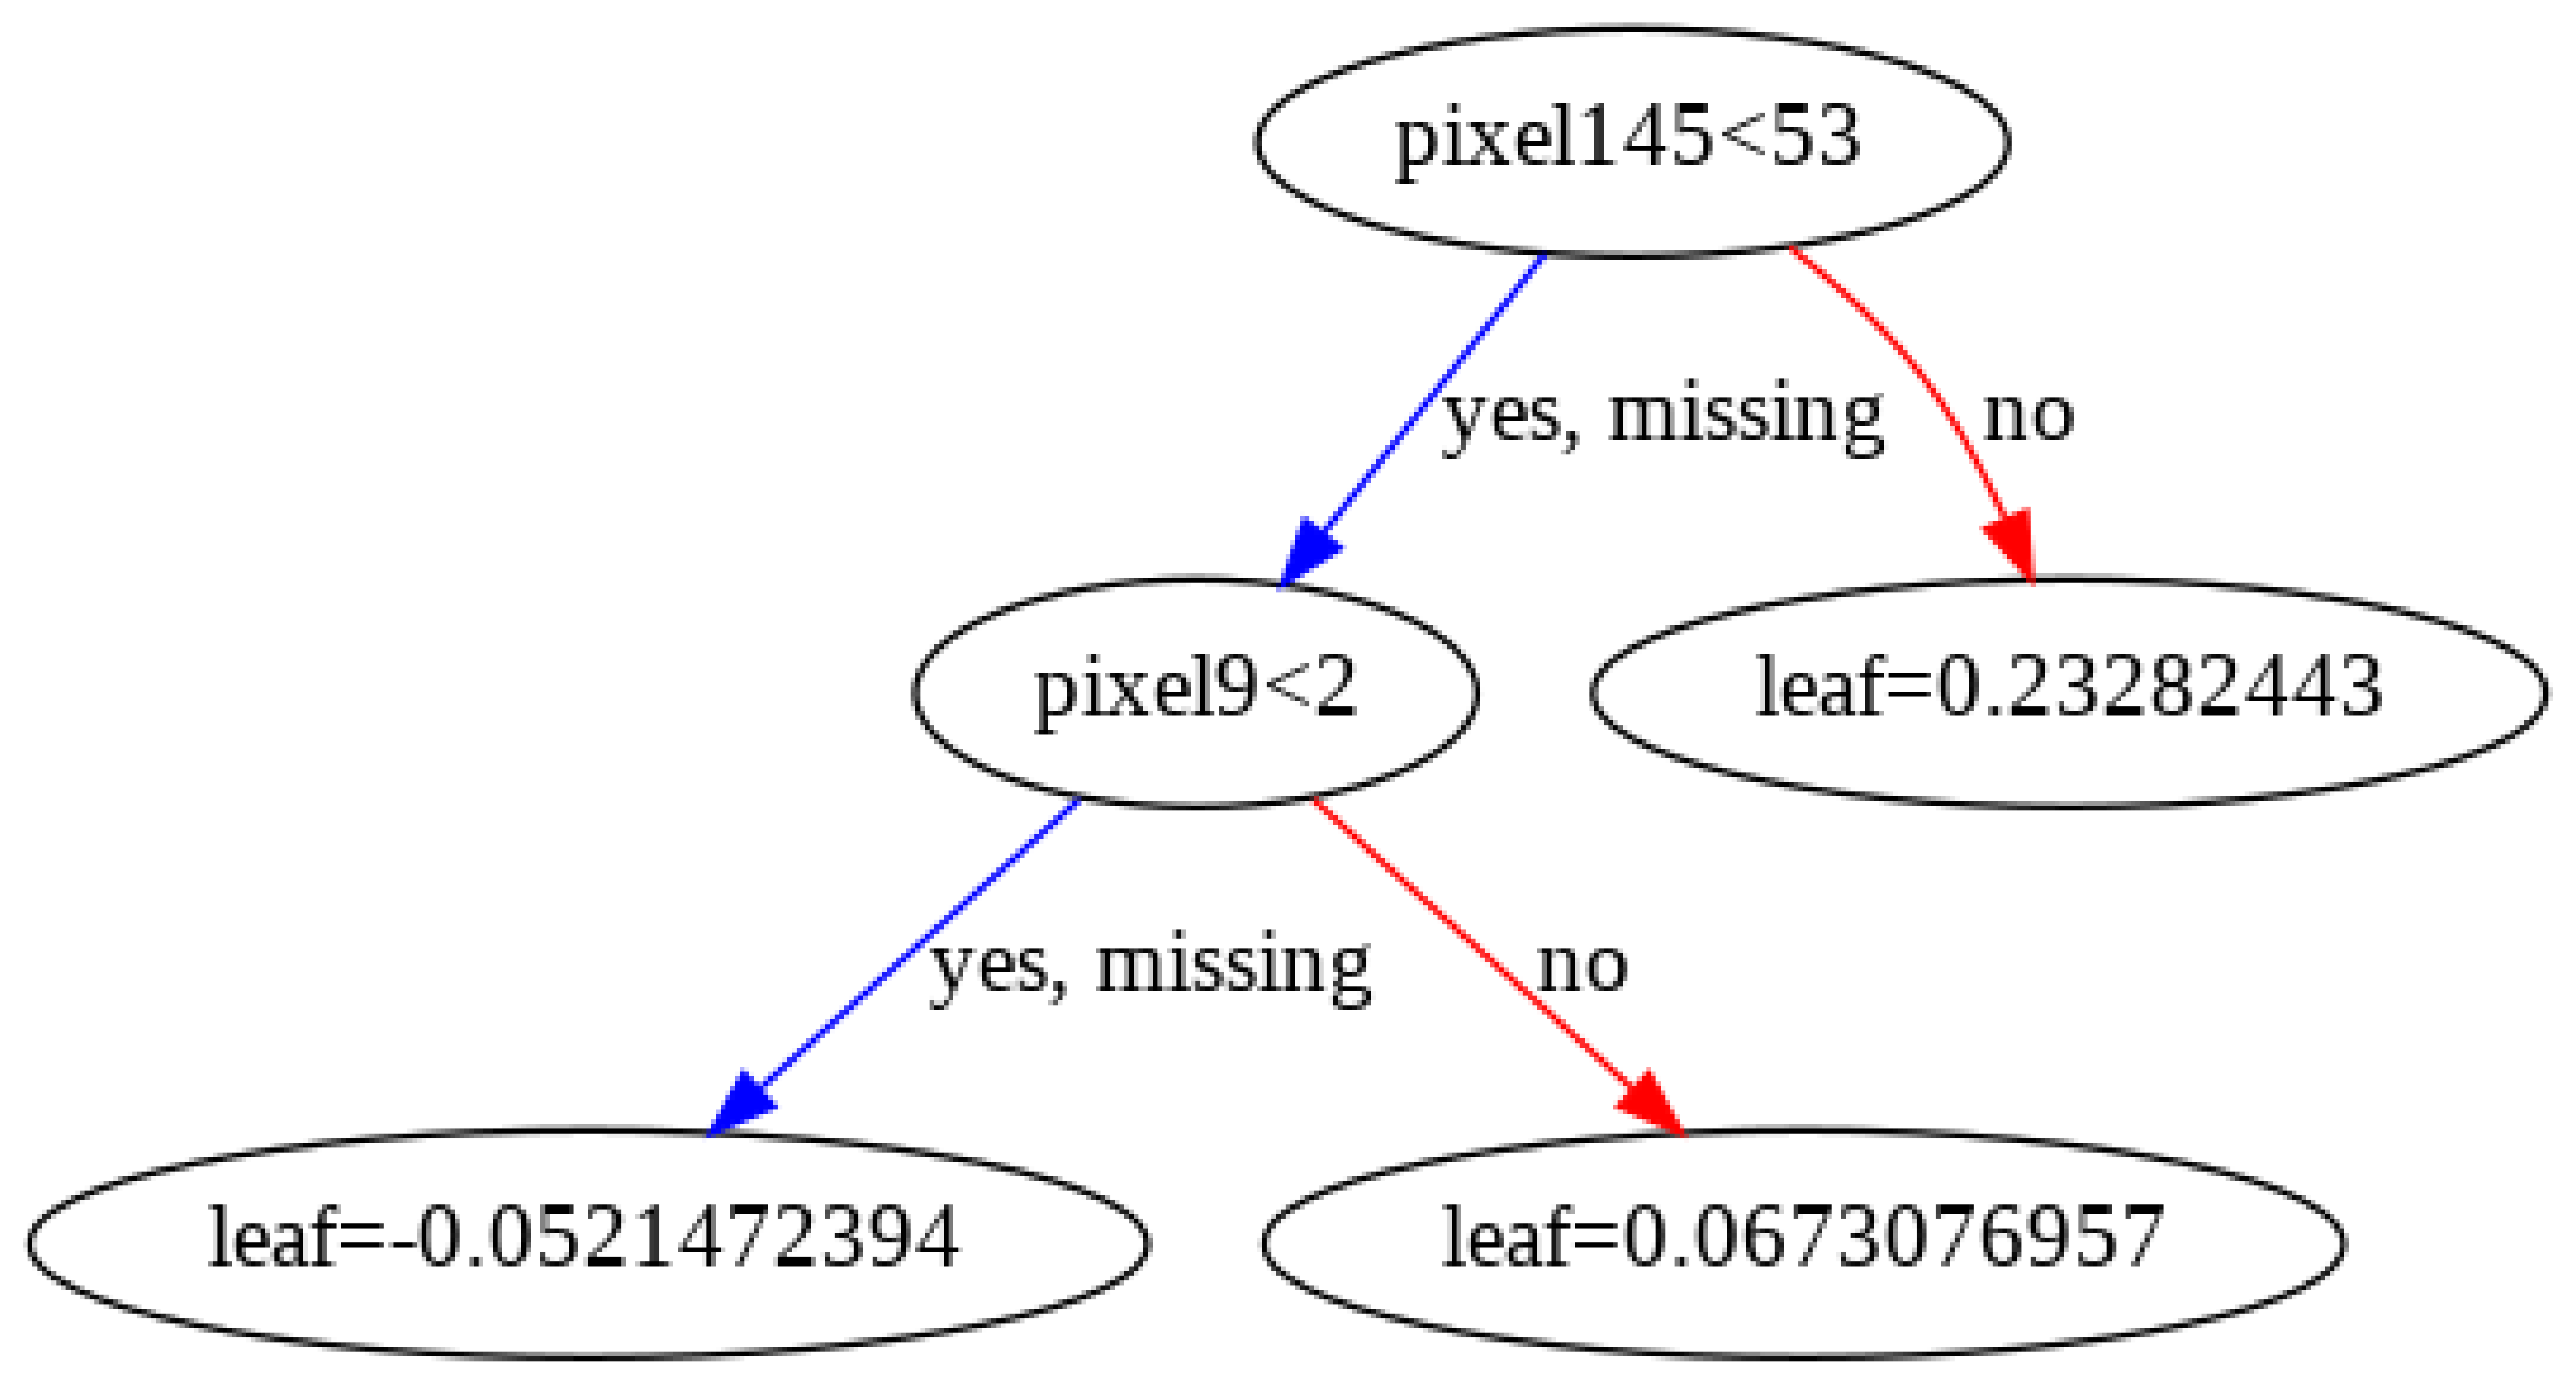

In [35]:
# XGBoost
xgb.plot_tree(xgboost);

**CatBoost**

CatBoost ships with no plotting function for its trees. If you really need to visualize CatBoost results, a work-around is proposed here: https://blog.csdn.net/l_xzmy/article/details/81532281

In [36]:
# Clear memory before moving onto the next round
import gc
gc.collect()

4603

In [37]:
del [[X_train]]